# Explainable AI for Machine Fault Diagnosis: Understanding Features’ Contribution in Machine Learning Models for Industrial Condition Monitoring

This notebook demonstrates how to use Support Vector Machine (SVM) and k-Nearest Neighbors (kNN) models for machine fault diagnosis using vibration data. The SHapley Additive exPlanation (SHAP) values are computed to interpret the models and identify the most important features contributing to the diagnosis.

The models and analysis presented here are part of a study aimed at understanding the feature contributions in machine learning models for industrial condition monitoring, as described in the referenced paper [1].

[1] Brusa, E., Cibrario, L., Delprete, C., & Di Maggio, L.G. (2023). Explainable AI for Machine Fault Diagnosis: Understanding Features’ Contribution in Machine Learning Models for Industrial Condition Monitoring. *Applied Sciences*, 13(4), 2038. [https://doi.org/10.3390/app13042038](https://doi.org/10.3390/app13042038)

In [2]:
!pip install shap


## Importing Necessary Libraries

We begin by importing the necessary Python libraries for data manipulation, machine learning model training, SHAP value computation, and plotting. These include `numpy` for numerical operations, `pandas` for handling dataframes, `shap` for SHAP value computation, `sklearn` for machine learning, and `matplotlib` for visualization.

In [17]:

import numpy as np
import pandas as pd
import shap
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


import matplotlib.pyplot as plt

## Data Loading

The dataset used for this analysis contains simulated vibration data generated to mimic the behavior of industrial bearings under various conditions. Unlike the experimental data used in the referenced paper, which was collected from real-world industrial bearings, the data here is the result of numerical simulations specifically designed to replicate the same fault conditions and bearing types described in the study. This simulated data is stored in a CSV file, which we load into a Pandas DataFrame for further processing.

In [18]:
dataDir = r'./data'
outDir = r'./output'

data = pd.read_csv(os.path.join(dataDir,'Data_sim.csv'))

## Feature Selection and Data Splitting

The features selected for this analysis are the same as those indicated in the referenced paper by Brusa et al. (2023). These features include various time-domain and frequency-domain metrics derived from the vibration signals, such as skewness, kurtosis, and specific frequency components, which are critical for diagnosing faults in bearings.

Below is the table of features used, as described in the paper:

![Table of Features](images/feature_table.png)

The data is then split into training and validation sets, with 1600 samples used for training and 400 for validation.

## Dataset Visualization using t-SNE

To better understand the distribution of the dataset and the relationships between different classes, we use t-Distributed Stochastic Neighbor Embedding (t-SNE), a dimensionality reduction technique. t-SNE helps visualize high-dimensional data by reducing it to two or three dimensions, making it easier to plot and interpret. Here, we apply t-SNE to the selected features in the dataset to see how the different classes are distributed in a lower-dimensional space.

In [19]:
X = data.iloc[:, 6:29]  # Select all features
y = data['Defect_type']

# Split data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=1600, test_size=400, random_state=42)

In [20]:
from sklearn.manifold import TSNE
import seaborn as sns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_X)

# Perform t-SNE on the dataset
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)  # X_scaled is the feature set aftwe scaling

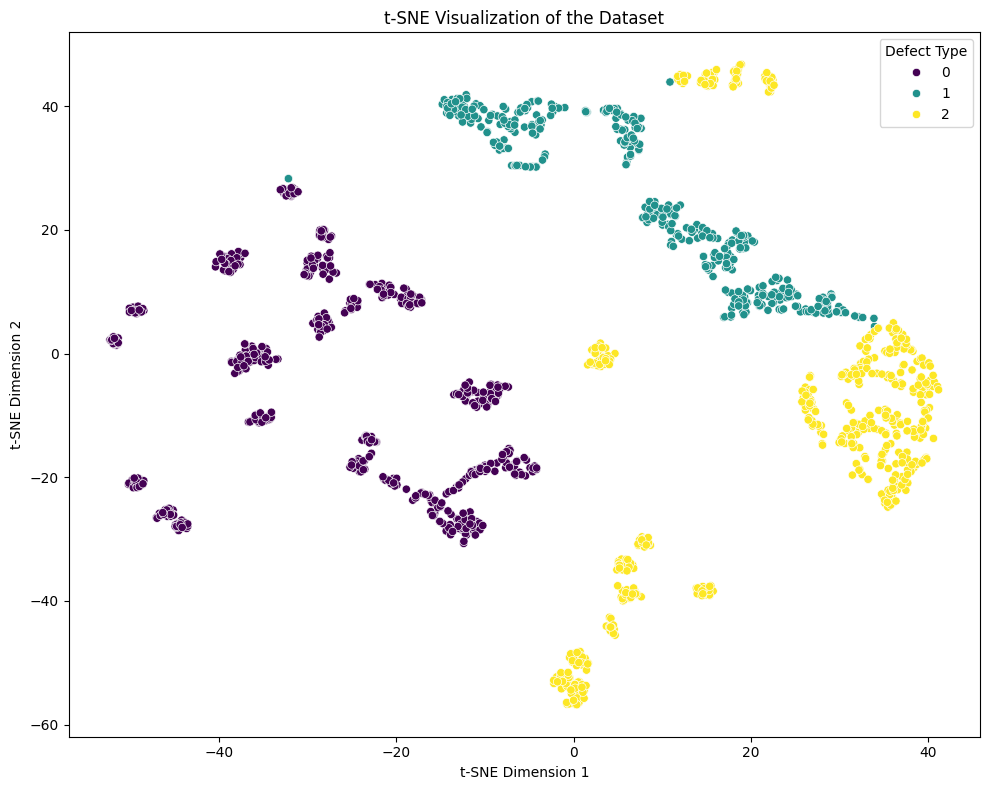

In [7]:
# Create a DataFrame with the t-SNE results and the labels
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Defect_type'] = train_y.values  # y contains the labels

# Plot the t-SNE result
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Defect_type', data=tsne_df, palette='viridis')
plt.title('t-SNE Visualization of the Dataset')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Defect Type')
plt.tight_layout()
plt.show()


## Model Training - SVM and kNN

Two machine learning models are trained for fault diagnosis: a Support Vector Machine (SVM) and a k-Nearest Neighbors (kNN) classifier. Each model is optimized using grid search cross-validation to find the best hyperparameters that yield the highest accuracy on the training data.

In [21]:
# Define SVM pipeline and hyperparameter grid
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()), 
    ("svm", svm.SVC(probability=True, decision_function_shape="ovo"))
])

svm_param_grid = {'svm__C': np.linspace(1, 100, 50), 'svm__kernel': ['poly', 'rbf', 'sigmoid']}

svm_clf = GridSearchCV(svm_pipeline, param_grid=svm_param_grid, cv=5, scoring='accuracy')
svm_clf.fit(train_X, train_y)
print('Best SVM score:', svm_clf.best_score_)

# Define kNN pipeline and hyperparameter grid
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()), 
    ("knn", KNeighborsClassifier())
])

knn_param_grid = {'knn__n_neighbors': range(1, 11)}

knn_clf = GridSearchCV(knn_pipeline, param_grid=knn_param_grid, cv=5, scoring='accuracy')
knn_clf.fit(train_X, train_y)
print('Best kNN score:', knn_clf.best_score_)

#Define Random Forest pipeline and hyperparameter grid
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Scaling is optional for Random Forest but can help
    ("rf", RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10]
}

rf_clf = GridSearchCV(rf_pipeline, param_grid=rf_param_grid, cv=5, scoring='accuracy')
rf_clf.fit(train_X, train_y)
print('Best Random Forest score:', rf_clf.best_score_)
print('Best parameters:', rf_clf.best_params_)

Best SVM score: 0.999375
Best kNN score: 0.9981250000000002
Best Random Forest score: 0.9974999999999999
Best parameters: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}


## SHAP Value Computation

To interpret the predictions of the SVM and kNN models, we compute SHAP (SHapley Additive exPlanations) values. SHAP values are a powerful tool for understanding the contribution of each feature to the model’s predictions, making the model more transparent and explainable.

SHAP values are based on the concept of Shapley values from cooperative game theory, which were originally used to distribute payouts among players depending on their contribution to the total payoff. In the context of machine learning, each feature is considered a "player" and the "payoff" is the prediction made by the model.

The SHAP value for a feature represents the average contribution of that feature to the difference between the model’s prediction for a specific instance and the average prediction for all instances. Mathematically, the SHAP value \(\phi_j\) for feature \(j\) is given by:

$$
\phi_j(v) = \sum_{S \subseteq M \setminus \{j\}} \frac{|S|! \cdot (d - |S| - 1)!}{d!} \left[ v(S \cup \{j\}) - v(S) \right]
$$

where:
- $(S)$ is a subset of features that does not include $(j)$,
- $(d)$ is the total number of features,
- $(v(S))$ is the contribution function that represents the expected model output given the features in subset $(S)$.

In simpler terms, SHAP values help us understand how each feature impacts the model’s prediction, both positively and negatively, by considering all possible combinations of features. This method is particularly valuable for creating interpretable models in the field of machine fault diagnosis, as it allows us to identify which features are most influential in predicting faults.

As discussed in the referenced paper by Brusa et al. (2023), SHAP values have been successfully applied to explain the decisions of machine learning models in industrial condition monitoring, specifically for diagnosing faults in medium-sized industrial bearings. The analysis in the paper showed that features like skewness and shape factor had the greatest impact on the model's outcomes, highlighting the practical importance of these explanations in real-world applications.

In this sample code, we use simulated data and results could differ from experimental SHAP.


In [ ]:
evalPoints = 200

# SHAP computation for SVM
svm_explainer = shap.KernelExplainer(svm_clf.predict_proba, shap.kmeans(train_X, 50))
svm_shap_values = svm_explainer.shap_values(train_X.iloc[1:evalPoints, :].values)

# SHAP computation for kNN
knn_explainer = shap.KernelExplainer(knn_clf.predict_proba, shap.kmeans(train_X, 50))
knn_shap_values = knn_explainer.shap_values(train_X.iloc[1:evalPoints, :].values)

# SHAP computation for Random Forest
rf_explainer = shap.KernelExplainer(rf_clf.predict_proba, shap.kmeans(train_X, 50))
rf_shap_values = rf_explainer.shap_values(train_X.iloc[1:evalPoints, :].values)

D:\SomosreeDas\Explainable-AI-for-Machine-Fault-Diagnosis\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
  0%|                                                                                          | 0/199 [00:00<?, ?it/s]D:\SomosreeDas\Explainable-AI-for-Machine-Fault-Diagnosis\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\SomosreeDas\Explainable-AI-for-Machine-Fault-Diagnosis\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
  1%|▍                                                                                 | 1/199 [00:01<05:36,  1.70s/it]D:\SomosreeDas\Explainable-AI-for-Machine-Fault-Diagnosis\venv\Lib\site-packages\sklearn\base.py:493: UserWa

## Visualization - SHAP Summary Plots

We generate summary plots to visualize the SHAP values for the top features contributing to the classification of different fault types. These plots help us understand which features have the most impact on the model’s decisions for each fault class.

In [15]:
# for i in range(3):
#     # Extract SHAP values for the i-th class for each sample
#     svm_class_shap_values = np.array([sv[:, i] for sv in svm_shap_values])
#     knn_class_shap_values = np.array([kv[:, i] for kv in knn_shap_values])
#     mlp_class_shap_values = np.array([mv[:, i] for mv in mlp_shap_values])


#     # SVM plots
#     shap.summary_plot(svm_class_shap_values, train_X.iloc[1:evalPoints, :], max_display=10, show=False)
#     plt.title(f'SVM Class {i}')
#     plt.savefig(os.path.join(outDir, f'SHAP_SVM_Class_{i}.png'), dpi=300, bbox_inches='tight')
#     plt.show()  # This displays the plot in the notebook
#     plt.clf()   # Clears the figure after saving and displaying

#     # kNN plots
#     shap.summary_plot(knn_class_shap_values, train_X.iloc[1:evalPoints, :], max_display=10, show=False)
#     plt.title(f'kNN Class {i}')
#     plt.savefig(os.path.join(outDir, f'SHAP_kNN_Class_{i}.png'), dpi=300, bbox_inches='tight')
#     plt.show()  # This displays the plot in the notebook
#     plt.clf()   # Clears the figure after saving and displaying

#     # MLP plots
#     shap.summary_plot(mlp_class_shap_values, train_X.iloc[1:evalPoints, :], max_display=10, show=False)
#     plt.title(f'MLP Class {i}')
#     plt.savefig(os.path.join(outDir, f'SHAP_MLP_Class_{i}.png'), dpi=300, bbox_inches='tight')
#     plt.show()  # This displays the plot in the notebook
#     plt.clf()   # Clears the figure after saving and displaying

# Create SHAP plots for each class
for i in range(3):  # Assuming 3 classes
    print(f"Creating plots for Class {i}...")
    
    # SVM plots
    shap.summary_plot(svm_shap_values[i], train_X.iloc[:evalPoints, :], max_display=10, show=False)
    plt.title(f'SVM Class {i}')
    plt.savefig(os.path.join(outDir, f'SHAP_SVM_Class_{i}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()
    
    # kNN plots
    shap.summary_plot(knn_shap_values[i], train_X.iloc[:evalPoints, :], max_display=10, show=False)
    plt.title(f'kNN Class {i}')
    plt.savefig(os.path.join(outDir, f'SHAP_kNN_Class_{i}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()
    
    # MLP plots
    shap.summary_plot(mlp_shap_values[i], train_X.iloc[:evalPoints, :], max_display=10, show=False)
    plt.title(f'MLP Class {i}')
    plt.savefig(os.path.join(outDir, f'SHAP_MLP_Class_{i}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()

print("SHAP analysis complete!")


Creating plots for Class 0...


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

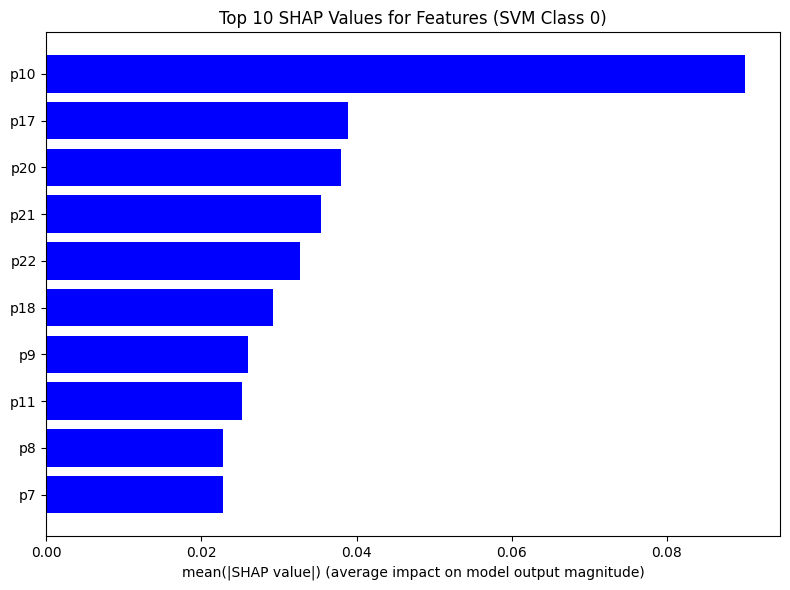

<Figure size 640x480 with 0 Axes>

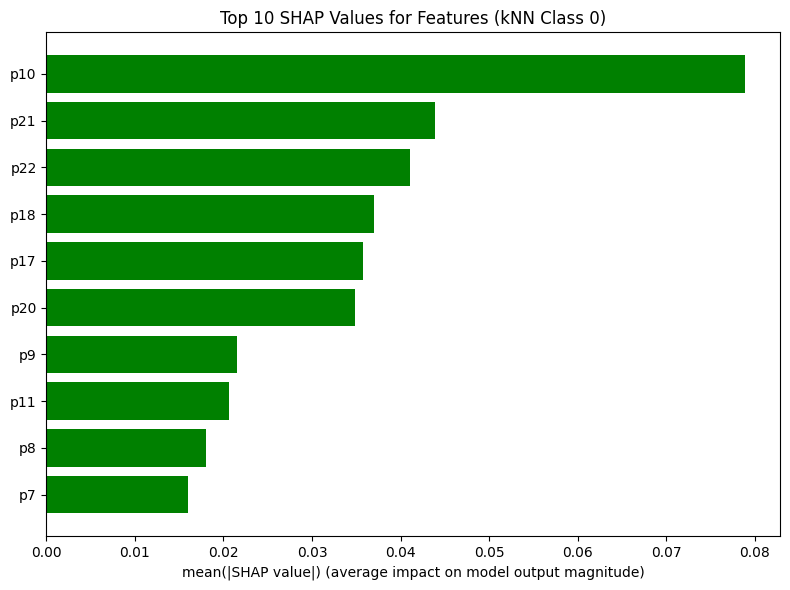

<Figure size 640x480 with 0 Axes>

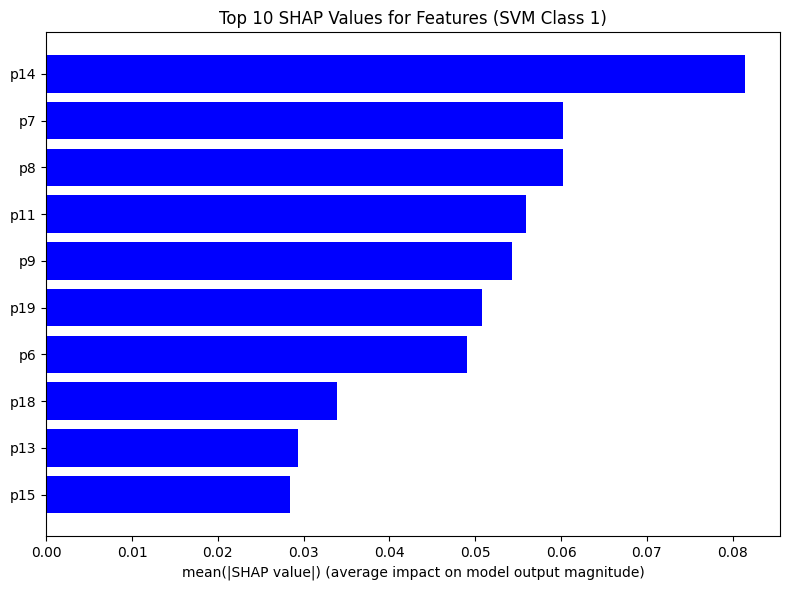

<Figure size 640x480 with 0 Axes>

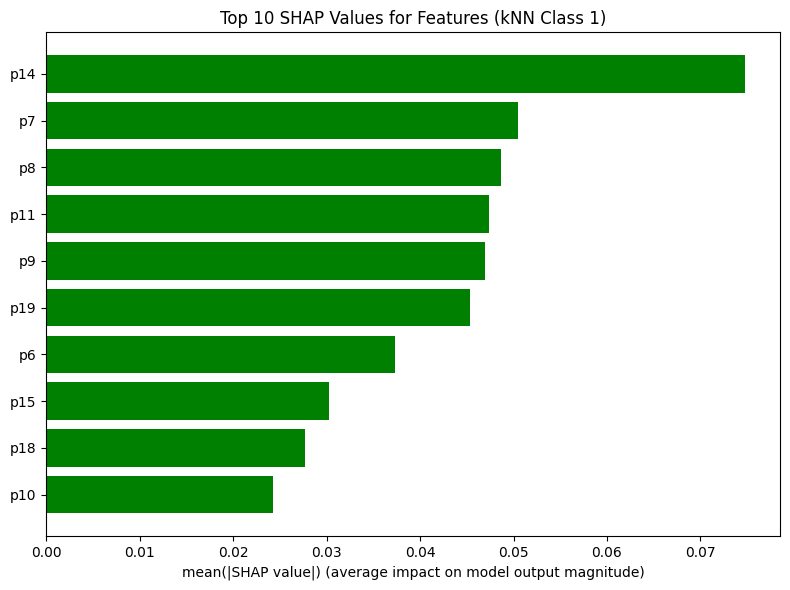

<Figure size 640x480 with 0 Axes>

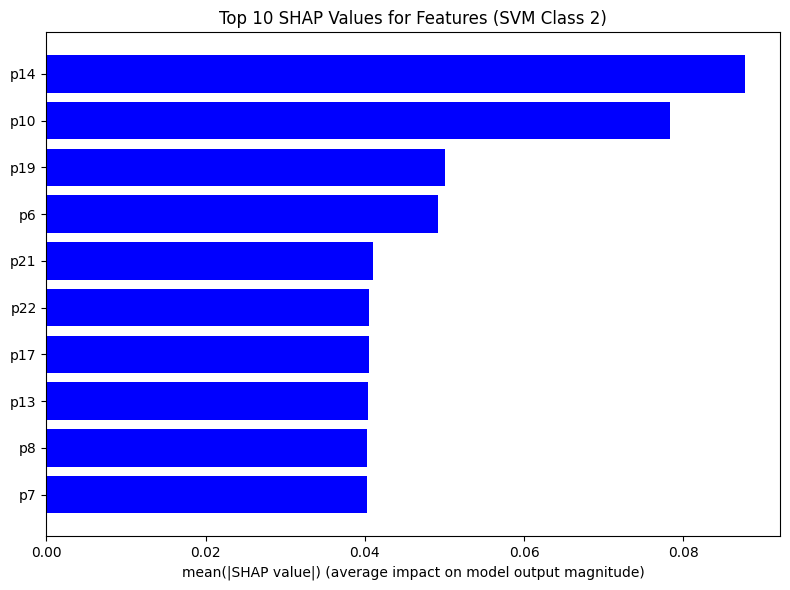

<Figure size 640x480 with 0 Axes>

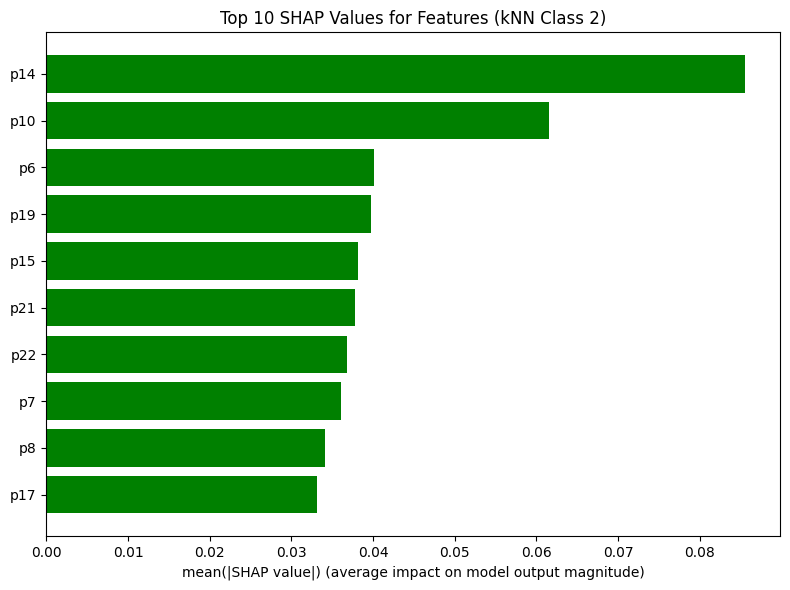

<Figure size 640x480 with 0 Axes>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os

for i in range(3):  
    # SVM: Calculate and sort mean SHAP values
    mean_svm_shap_values = np.mean(np.abs([sv[:, i] for sv in svm_shap_values]), axis=0)
    sorted_indices_svm = np.argsort(mean_svm_shap_values)[::-1]  # Sort indices in descending order
    sorted_svm_shap_values = mean_svm_shap_values[sorted_indices_svm][:10]  # Keep top 10
    sorted_svm_features = train_X.columns[sorted_indices_svm][:10]  # Keep top 10 features

    # kNN: Calculate and sort mean SHAP values
    mean_knn_shap_values = np.mean(np.abs([kv[:, i] for kv in knn_shap_values]), axis=0)
    sorted_indices_knn = np.argsort(mean_knn_shap_values)[::-1]  # Sort indices in descending order
    sorted_knn_shap_values = mean_knn_shap_values[sorted_indices_knn][:10]  # Keep top 10
    sorted_knn_features = train_X.columns[sorted_indices_knn][:10]  # Keep top 10 features

    # Plot SVM SHAP values (Top 10 features)
    plt.figure(figsize=(8, 6))
    plt.barh(sorted_svm_features[::-1], sorted_svm_shap_values[::-1], color='blue')  # Reverse for descending order
    plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
    plt.title(f"Top 10 SHAP Values for Features (SVM Class {i})")
    plt.tight_layout()
    plt.savefig(os.path.join(outDir, f'Top10_SHAP_Values_SVM_Class_{i}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()

    # Plot kNN SHAP values (Top 10 features)
    plt.figure(figsize=(8, 6))
    plt.barh(sorted_knn_features[::-1], sorted_knn_shap_values[::-1], color='green')  # Reverse for descending order
    plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
    plt.title(f"Top 10 SHAP Values for Features (kNN Class {i})")
    plt.tight_layout()
    plt.savefig(os.path.join(outDir, f'Top10_SHAP_Values_kNN_Class_{i}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()


# Conclusion

In this notebook, we demonstrated how to use SVM and kNN models for machine fault diagnosis. We utilized SHAP values to interpret the models, providing insights into which features are most important for accurate fault classification. The SHAP analysis revealed that specific time-domain and frequency-domain features, such as skewness and shape factor, are critical in diagnosing faults in industrial bearings.

This approach not only improves the transparency of machine learning models in industrial condition monitoring but also aids in feature selection, potentially enhancing model robustness and accuracy.